# Plot PyGEM output for simulations 2020-2100

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import json
import matplotlib.pyplot as plt
import cmocean
import glob
from datetime import datetime
from scipy.stats import shapiro, ttest_ind, mannwhitneyu, wilcoxon, wasserstein_distance


In [2]:
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 'medium'
plt.rcParams['ytick.labelsize'] = 'medium'
plt.rcParams['legend.fontsize'] = 16


### Locate files

In [3]:
# PyGEM output
rgi_regions = ['1']*8
rgi_glacs = ['26722']*8 # Kennicott (15645), Root (26722)
gcms = ['CESM2', 'CESM2-WACCM', 'BCC-CSM2-MR', 'EC-EARTH3', 'EC-EARTH3-Veg', 'FGOALS-f3-L',
        'GFDL-ESM4', 'INM-CM4-8', 'INM-CM5-0', 'MPI-ESM1-2-HR', 'MRI-ESM2-0', 'NorESM2-MM']
option_calibs = ['MCMC', 'MCMC', 'MCMC', 'MCMC', 'opt', 'opt', 'opt', 'opt'] # 'MCMC', 'kp', 'opt'
scenarios = ['ssp126', 'ssp245', 'ssp370', 'ssp585']*2
start_yrs = [2000]*8
end_yrs = [2100]*8


In [4]:
# open dataset
nc_datas = []
for gcm in gcms:
    gcm_data = []
    for rgi_region, rgi_glac, option_calib, scenario, start_yr, end_yr in zip(rgi_regions, rgi_glacs, option_calibs, 
                                                                                   scenarios, start_yrs, end_yrs):
        # glena = '_regional_glena' # regional glena
        glena = '' # glacier-specific glena
        fp = f'simulations/gridsearch/rounce_mcmc_from{start_yr}{glena}/{gcm}/{scenario}/stats/'
        fn = f'{rgi_region}*{rgi_glac}*{gcm}*{scenario}*{option_calib}*{end_yr}_all.nc'
        fl = glob.glob(fp+fn)
        
        assert len(fl) == 1, f"Expected exactly one file match, but found {len(fl)} files."
        nc_data = xr.open_dataset(fl[0])
        gcm_data.append(nc_data)
    nc_datas.append(gcm_data)


Import historical ERA5 data

In [5]:
era5_yrs = np.array([1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 
                     1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 
                     1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 
                     1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 
                     2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023])
if rgi_glacs[0] == '15645':
    era5_gt = np.array([60.43079911, 60.37863836, 60.38926917, 60.35517128, 60.44124861, 60.49769378, 60.58965243, 60.51986607, 60.5120368, 
                        60.49109284, 60.52141329, 60.34238281, 60.19582379, 60.21385592, 60.09984514, 60.00056821, 60.02335508, 60.09138098, 
                        59.92498705, 59.81793037, 59.76006138, 59.78451055, 59.77989254, 59.75120658, 59.71502376, 59.70812778, 59.69069559, 
                        59.59368591, 59.46476207, 59.38613254, 59.21601356, 59.23420382, 59.2242234 , 59.16275668, 59.08948713, 59.02516092, 
                        58.96734048, 58.92033436, 58.82068602, 58.68562718, 58.54720569, 58.49141861, 58.47352761, 58.35390058, 58.25566023,
                        58.17297394, 58.22874841, 58.18334064, 58.14672872, 58.13631287, 57.95047184, 57.82559983, 57.75315467, 57.75267401, 
                        57.6356553, 57.52151975, 57.28068881, 57.17169667, 57.02077011, 56.91041999, 56.85104831, 56.82516955, 56.73098779, 
                        56.67892831, 56.58095015, 56.42265855, 56.32009485, 56.24215663, 56.04597705, 56.00446334, 55.8074314 , 55.6549294, 
                        55.56045326, 55.48680993, 55.33240476, 55.19130799, 55.05716162, 54.78732476, 54.63760401, 54.52776547, 54.29330105, 
                        54.14409608, 53.96818738, 53.92125906])
    era5_smb = np.array([-14.85903527,   3.02859556,  -9.71099466,  24.51397822, 16.07199603,  26.1768839 , -19.84466484,  -2.22169114,
                         -5.94848222,   8.62130101, -50.84519252, -41.6293745 , 5.1296276 , -32.37007729, -28.19056056,   6.47691876,
                         19.31623622, -47.22172602, -30.39010536, -16.42538111, 6.94566408,  -1.30764929,  -8.13960628, -10.26733157,
                         -1.95133405,  -4.94054883, -27.52372177, -36.57581489, -22.30928177, -48.27280189,   5.1715498 ,  -2.82242694,
                         -17.43597152, -20.78941807, -18.24430145, -16.40551749, -13.32769641, -28.26845529, -38.32901014, -39.28891677,
                         -15.8300735 ,  -5.06460931, -33.95861844, -27.88874143, -23.47199801,  15.85986676, -12.87699962, -10.38026751, 
                         -2.93953222, -52.75926986, -35.46041662, -20.57161211, -0.1130078 , -33.23035175, -32.42588171, -68.46074044, 
                         -30.98833992, -42.91003569, -31.38744817, -16.86999461, -7.34355487, -26.78151398, -14.79708312, -27.8772989 ,
                         -45.04070856, -29.18639966, -22.18529517, -55.88770448, -11.81408026, -56.1547172 , -43.47644399, -26.92965045,
                         -20.99250616, -44.02739837, -40.2528386 , -38.27783044, -77.06264298, -42.76244117, -31.37407926, -67.01969384, 
                         -42.66272058, -50.32463738, -13.39168])
    era5_smb_min = np.array([-31.59047982, -9.57026064, -18.93443225, -2.13510274, -2.50306218, 3.29852148,  -26.72376701,  -11.67809186,
                             -15.92141698, -5.11741654, -83.95153031, -61.80764283, -9.48993958,  -45.57147579,  -40.97177139, -7.55606328,
                             -4.12489912, -70.47225301, -42.16777905, -23.03964342, -8.74043068, -12.11173235, -16.95848219, -17.22888019,
                             -12.46416255, -13.80817879, -39.27273749, -53.53577648, -32.78734564, -76.5876778, -8.25374332, -14.70931305,
                             -24.73858031, -38.48858282, -25.97024442, -24.92838729, -26.13991902, -42.88915115, -54.03003927, -58.05135111,
                             -27.04381031, -15.42639731, -49.05912158, -42.66181647, -33.61741869, -3.83729177, -21.7858819, -19.07429546,
                             -15.2897561, -81.90128368, -49.78613325, -27.98530944, -19.22769846, -46.76116827, -50.08746993, -107.50686484,
                             -44.59299183, -63.92714038, -49.78582114, -31.58607213, -16.80579933, -43.40572678, -24.21786355, -38.97609545,
                             -82.00219769, -43.67549224, -29.66291402, -86.16349461, -19.4909349, -85.7330371, -63.40345933, -37.83903249,
                             -30.49484392, -69.8777594, -58.76385355, -55.23930407, -119.37323242, -61.77315611, -43.4814232, -112.04406904,
                             -64.7215513, -74.98082534, -34.74348712])
    era5_smb_max = np.array([ -2.57354757,  18.47426732,   0.65777227,  55.57498042, 39.21565817, 54.96719688, -12.45608031, 7.05786306,
                             5.02380133, 25.23836306, -27.24433606, -24.92699605, 20.33653321, -20.94757296, -15.40896644, 27.24783225,
                             54.28941324, -30.09647316, -18.09716813, -8.26768689, 27.64863656, 10.64248849,  -0.82051735, -1.66334493,
                             10.05570093, 4.2233231, -15.99726368, -22.30987415, -11.87478213, -26.179099, 20.98408238, 11.83665678,
                             -9.04181265, -8.3042377, -9.99456959, -6.87075106, 3.80873889, -16.5823036, -22.79517938, -25.33351173,
                             -5.88014043, 4.4389365, -20.30922332, -16.40120245, -13.49005521, 44.92604778, -2.5121262, -0.74066709,
                             8.98455268, -32.57115458, -23.20466805, -12.32940527, 28.04837706, -21.64011805, -20.82603844, -39.59234308,
                             -17.82205495, -27.97201013, -15.44555667, -1.31529169, 2.20623536, -13.50679121, -4.71802346, -17.15329677,
                             -22.18491977, -15.88014768, -13.91253676, -34.31074509, -3.85908684, -34.98738197, -24.82685424, -16.36711756,
                             -11.3097784, -25.75916648, -26.30751316, -25.74815251, -45.78810908, -28.16957052, -18.85343371, -39.23188366,
                             -26.82994496, -31.08410996, 11.41009943])
if rgi_glacs[0] == '26722':
    era5_gt = np.array([14.34882407, 14.33845407, 14.33332621, 14.32030537, 14.32800319, 14.33012571, 14.34374553, 14.32540228, 14.32130555, 
                        14.32252891, 14.31541542, 14.27970198, 14.25131303, 14.25014637, 14.22008804, 14.19278126, 14.19095683, 14.19152498, 
                        14.14560573, 14.11805028, 14.09785657, 14.09243318, 14.09243256, 14.07606722, 14.06666134, 14.04993779, 14.04964302, 
                        14.02746053, 13.99636979, 13.98208542, 13.96379649, 13.96397343, 13.94917106, 13.92883329, 13.90569104, 13.88734065, 
                        13.864032, 13.84690773, 13.81706123, 13.78798207, 13.75388135, 13.73902463, 13.72690433, 13.69785878, 13.66877144, 
                        13.65120094, 13.65427404, 13.64720344, 13.63724472, 13.61859875, 13.57590076, 13.54390566, 13.52819387, 13.50978555, 
                        13.48229057, 13.45764637, 13.40133201, 13.37899651, 13.34633186, 13.32322402, 13.30218755, 13.28714886, 13.25593579, 
                        13.23979682, 13.2166427, 13.17857534, 13.15195872, 13.12885138, 13.08544623, 13.06885156, 13.03288951, 12.99923067, 
                        12.96986527, 12.94920454, 12.91551478, 12.88028847, 12.85094112, 12.79940778, 12.76353728, 12.73405604, 12.6918844, 
                        12.64689136, 12.61186529, 12.59197608])
    era5_smb = np.array([-10.477671, -5.181542, -13.158946, 7.780807, 2.145286, 13.767081, -18.540916, -4.142952, 1.236298, -7.19338, 
                         -36.114401, -28.719421, -1.180491, -30.419663, -27.646572, -1.847934, 0.576263, -46.512328, -27.926702, -20.472678, 
                         -5.501337, -0.001505, -16.598352, -9.542824, -16.967686, -0.300891, -22.513913, -31.562644, -14.508308, -18.577886, 
                         0.177895, -15.036543, -20.666903, -23.523466, -18.657351, -23.705935, -17.418647, -30.367631, -29.600213, -34.72277, 
                         -15.134506, -12.348903, -29.601683, -29.652759, -17.918597, 3.134586, -7.21293, -10.160137, -19.023592, -43.578891, 
                         -32.672661, -16.052613, -18.805383, -28.102463, -25.196997, -57.599654, -22.859209, -33.438528, -23.667015, 
                         -21.548243, -15.410564, -31.989578, -16.548414, -23.745773, -39.049879, -27.320119, -23.727582, -44.584779, 
                         -17.054437, -36.966446, -34.613488, -30.21064, -21.267842, -34.70188, -36.313593, -30.26583, -53.196742, -37.055005, 
                         -30.489068, -43.635306, -46.583518, -36.308094, -20.598138])
    era5_smb_min = np.array([-24.082154, -10.23272, -21.269062, -3.613482, -5.225794, 3.57451, -22.656487, -13.97425, -4.721268, -12.04607, 
                             -49.063471, -35.751038, -8.030153, -44.868097, -35.748261, -7.378196, -8.272342, -64.033128, -39.230829, 
                             -28.141078, -14.21895, -5.833986, -23.356728, -13.852333, -23.726861, -8.352118, -29.745719, -44.689617, 
                             -21.336504, -26.141907, -7.642877, -22.897485, -28.454235, -30.701594, -23.786549, -31.619338, -24.350507, 
                             -44.525915, -39.531949, -49.839991, -18.612762, -16.287837, -39.712074, -41.954467, -23.256382, -4.007844, 
                             -11.284447, -13.736231, -27.631652, -60.797935, -45.214197, -22.261396, -31.145675, -38.587806, -37.654564, 
                             -81.825126, -32.552199, -50.279163, -30.86259, -33.15604, -20.417889, -50.37523, -21.444955, -35.332472, 
                             -61.729662, -39.025883, -34.143189, -66.378956, -22.967491, -55.524684, -52.092172, -46.923735, -28.524041, 
                             -48.266426, -49.796754, -42.450818, -69.473312, -50.303463, -42.541861, -56.068487, -62.340286, -49.239019, 
                             -31.381863])
    era5_smb_max = np.array([-0.20704, 0.636453, -3.285555, 18.338267, 10.995682, 26.741723, -13.081367, 6.069021, 9.224618, 0.787757, 
                             -26.763309, -21.13462, 6.559748, -24.834258, -22.000183, 6.240617, 7.762028, -36.424092, -23.680816, -16.464166, 
                             5.839033, 9.166417, -12.761127, -2.562462, -11.073718, 10.849744, -17.723553, -25.880865, -7.192035, -13.918796, 
                             10.415873, -6.074259, -16.751261, -18.109325, -11.89399, -15.496598, -12.358043, -25.363702, -23.754173, 
                             -28.489027, -8.78956, -4.76458, -22.988546, -24.480289, -13.131566, 13.366244, 0.820623, -2.063505, -13.06598, 
                             -33.660745, -26.230159, -7.789373, -2.971412, -21.806866, -20.612446, -40.911088, -19.011361, -27.587047, 
                             -17.347034, -13.364385, -8.596609, -22.870324, -8.420386, -19.483908, -22.611312, -20.905359, -17.80572, 
                             -33.123379, -9.998189, -28.961733, -27.961473, -25.001559, -15.212718, -27.379775, -28.224792, -24.62407, 
                             -40.019297, -30.324319, -25.393492, -35.121696, -37.604571, -30.306069, -10.420525])


In [6]:
kp1940_yrs = np.array([1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 
                       1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 
                       1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 
                       1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 
                       2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 
                       2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 
                       2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072, 
                       2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091, 
                       2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100, 2101])
if rgi_glacs[0] == '15645':
    kp1940_gts = np.array([[60.431, 60.37, 60.311, 60.253, 60.159, 60.1, 60.087, 60.057, 60.0, 59.956, 59.902, 59.876, 59.847, 59.756, 
                            59.7, 59.646, 59.625, 59.583, 59.544, 59.53, 59.485, 59.465, 59.417, 59.405, 59.349, 59.295, 59.257, 59.229,
                            59.226, 59.186, 59.136, 59.065, 59.015, 58.985, 58.942, 58.895, 58.85, 58.777, 58.74, 58.689, 58.632, 58.562,
                            58.501, 58.448, 58.399, 58.338, 58.27, 58.217, 58.135, 58.07, 58.018, 57.936, 57.838, 57.807, 57.772, 57.679,
                            57.588, 57.486, 57.401, 57.305, 57.213, 57.117, 56.991, 56.86, 56.766, 56.666, 56.53, 56.425, 56.303, 56.232,
                            56.103, 56.018, 55.85, 55.699, 55.549, 55.391, 55.224, 55.046, 54.828, 54.652, 54.43, 54.252, 54.056, 53.878,
                            53.709, 53.505, 53.267, 53.071, 52.885, 52.666, 52.471, 52.286, 52.075, 51.807, 51.549, 51.324, 51.125, 50.874,
                            50.659, 50.431, 50.208, 49.971, 49.725, 49.48, 49.254, 49.009, 48.75, 48.514, 48.272, 48.008, 47.725, 47.448, 
                            47.2, 46.987, 46.772, 46.515, 46.25, 46.011, 45.747, 45.439, 45.214, 44.976, 44.739, 44.522, 44.301, 44.054, 
                            43.828, 43.62, 43.358, 43.068, 42.791, 42.579, 42.324, 42.072, 41.836, 41.627, 41.422, 41.135, 40.87, 40.645,
                            40.402, 40.165, 39.927, 39.647, 39.412, 39.169, 38.918, 38.657, 38.411, 38.15, 37.927, 37.666, 37.399, 37.172,
                            36.953, 36.736, 36.507, 36.328, 36.132, 35.932, 35.722, 35.52],
                           [60.431, 60.37, 60.308, 60.25, 60.154, 60.092, 60.077, 60.045, 59.986, 59.94, 59.884, 59.853, 59.824, 59.73, 
                            59.675, 59.621, 59.598, 59.556, 59.516, 59.5, 59.453, 59.43, 59.381, 59.367, 59.31, 59.258, 59.218, 59.188, 
                            59.185, 59.141, 59.09, 59.018, 58.966, 58.935, 58.89, 58.843, 58.797, 58.724, 58.685, 58.633, 58.575, 58.504,
                            58.44, 58.386, 58.336, 58.273, 58.203, 58.147, 58.062, 57.994, 57.942, 57.857, 57.756, 57.724, 57.687, 57.592,
                            57.5, 57.396, 57.307, 57.209, 57.115, 57.017, 56.889, 56.758, 56.665, 56.564, 56.428, 56.322, 56.199, 56.128, 
                            55.998, 55.912, 55.741, 55.588, 55.439, 55.286, 55.107, 54.954, 54.806, 54.67, 54.479, 54.269, 54.076, 53.882,
                            53.702, 53.533, 53.361, 53.144, 52.896, 52.669, 52.494, 52.289, 52.122, 51.895, 51.676, 51.446, 51.247, 51.034,
                            50.799, 50.587, 50.372, 50.136, 49.887, 49.647, 49.427, 49.15, 48.902, 48.614, 48.352, 48.069, 47.799, 47.539, 
                            47.315, 47.048, 46.749, 46.483, 46.217, 45.939, 45.653, 45.336, 44.975, 44.668, 44.337, 44.07, 43.743, 43.452,
                            43.139, 42.79, 42.532, 42.245, 41.905, 41.624, 41.299, 40.996, 40.641, 40.345, 40.048, 39.742, 39.438, 39.165,
                            38.847, 38.513, 38.185, 37.812, 37.486, 37.168, 36.851, 36.564, 36.223, 35.864, 35.545, 35.204, 34.872, 34.586,
                            34.284, 33.97, 33.628, 33.319, 33.04, 32.744, 32.487, 32.174],
                           [60.431, 60.366, 60.302, 60.241, 60.143, 60.08, 60.063, 60.029, 59.968, 59.92, 59.863, 59.833, 59.801, 59.705, 
                            59.647, 59.589, 59.564, 59.519, 59.476, 59.458, 59.409, 59.385, 59.332, 59.317, 59.258, 59.201, 59.158, 59.126,
                            59.121, 59.075, 59.022, 58.948, 58.893, 58.86, 58.813, 58.762, 58.713, 58.637, 58.595, 58.54, 58.479, 58.405, 
                            58.339, 58.28, 58.228, 58.164, 58.091, 58.034, 57.946, 57.876, 57.822, 57.734, 57.632, 57.598, 57.558, 57.46, 
                            57.365, 57.258, 57.167, 57.068, 56.971, 56.871, 56.741, 56.607, 56.514, 56.409, 56.27, 56.162, 56.037, 55.963,
                            55.831, 55.745, 55.572, 55.42, 55.267, 55.107, 54.934, 54.768, 54.579, 54.398, 54.25, 54.113, 54.003, 53.846,
                            53.646, 53.455, 53.266, 53.072, 52.805, 52.613, 52.422, 52.23, 52.007, 51.79, 51.568, 51.375, 51.168, 50.918, 
                            50.654, 50.434, 50.202, 49.974, 49.734, 49.483, 49.249, 48.978, 48.72, 48.412, 48.123, 47.871, 47.593, 47.349,
                            47.075, 46.812, 46.526, 46.186, 45.884, 45.557, 45.231, 44.851, 44.561, 44.179, 43.824, 43.465, 43.151, 42.797,
                            42.417, 42.027, 41.661, 41.307, 40.925, 40.555, 40.157, 39.735, 39.385, 39.039, 38.634, 38.26, 37.886, 37.482,
                            37.077, 36.635, 36.215, 35.762, 35.309, 34.874, 34.386, 33.909, 33.487, 33.079, 32.678, 32.265, 31.823, 31.37, 
                            30.903, 30.417, 29.96, 29.474, 29.028, 28.616, 28.196, 27.751],
                           [60.431, 60.369, 60.308, 60.25, 60.154, 60.094, 60.079, 60.048, 59.988, 59.943, 59.888, 59.859, 59.829, 59.736, 
                            59.681, 59.625, 59.603, 59.561, 59.521, 59.506, 59.459, 59.437, 59.387, 59.373, 59.318, 59.262, 59.219, 59.19, 
                            59.185, 59.144, 59.093, 59.021, 58.968, 58.936, 58.892, 58.844, 58.798, 58.724, 58.681, 58.629, 58.571, 58.5, 
                            58.438, 58.384, 58.333, 58.27, 58.201, 58.146, 58.062, 57.995, 57.944, 57.859, 57.759, 57.726, 57.689, 57.594,
                            57.501, 57.397, 57.31, 57.214, 57.12, 57.023, 56.896, 56.765, 56.673, 56.571, 56.434, 56.327, 56.205, 56.132, 
                            56.003, 55.916, 55.747, 55.595, 55.444, 55.289, 55.064, 54.865, 54.671, 54.491, 54.331, 54.194, 54.035, 53.842,
                            53.63, 53.394, 53.204, 52.996, 52.774, 52.541, 52.323, 52.097, 51.873, 51.634, 51.409, 51.15, 50.849, 50.617, 
                            50.347, 50.094, 49.848, 49.631, 49.361, 49.071, 48.783, 48.507, 48.202, 47.913, 47.572, 47.246, 46.882, 46.54,
                            46.249, 45.887, 45.498, 45.183, 44.806, 44.482, 44.132, 43.736, 43.295, 42.875, 42.495, 42.123, 41.734, 41.346,
                            40.926, 40.48, 40.083, 39.61, 39.187, 38.695, 38.221, 37.768, 37.239, 36.782, 36.269, 35.798, 35.328, 34.773, 
                            34.305, 33.819, 33.357, 32.805, 32.278, 31.767, 31.258, 30.742, 30.149, 29.603, 29.077, 28.548, 27.989, 27.506,
                            26.994, 26.433, 25.913, 25.375, 24.874, 24.376, 23.858, 23.378]])
if rgi_glacs[0] == '26722':
    kp1940_gts = np.array([[14.349, 14.334, 14.319, 14.302, 14.281, 14.267, 14.26, 14.251, 14.238, 14.226, 14.212, 14.203, 14.193, 14.172, 
                            14.157, 14.145, 14.136, 14.125, 14.113, 14.107, 14.096, 14.087, 14.075, 14.07, 14.058, 14.044, 14.033, 14.024, 
                            14.021, 14.01, 13.999, 13.982, 13.971, 13.962, 13.95, 13.937, 13.926, 13.909, 13.898, 13.884, 13.869, 13.853, 
                            13.838, 13.823, 13.812, 13.796, 13.778, 13.764, 13.743, 13.724, 13.709, 13.686, 13.661, 13.648, 13.636, 13.61, 
                            13.587, 13.562, 13.538, 13.513, 13.488, 13.462, 13.43, 13.397, 13.372, 13.343, 13.308, 13.276, 13.241, 13.215, 
                            13.18, 13.152, 13.107, 13.066, 13.029, 12.987, 12.942, 12.896, 12.841, 12.794, 12.74, 12.692, 12.64, 12.593, 
                            12.545, 12.495, 12.432, 12.382, 12.331, 12.275, 12.221, 12.171, 12.116, 12.049, 11.986, 11.928, 11.875, 11.812, 
                            11.757, 11.698, 11.64, 11.581, 11.519, 11.458, 11.4, 11.341, 11.28, 11.223, 11.165, 11.107, 11.044, 10.982, 
                            10.926, 10.878, 10.829, 10.773, 10.716, 10.665, 10.61, 10.546, 10.497, 10.448, 10.398, 10.354, 10.308, 10.261, 
                            10.215, 10.175, 10.125, 10.07, 10.02, 9.98, 9.934, 9.888, 9.845, 9.807, 9.77, 9.722, 9.677, 9.638, 9.596, 9.556, 
                            9.514, 9.467, 9.427, 9.385, 9.343, 9.301, 9.261, 9.218, 9.182, 9.14, 9.096, 9.06, 9.023, 8.988, 8.952, 8.922, 
                            8.89, 8.858, 8.824, 8.792],
                           [14.349, 14.334, 14.318, 14.301, 14.28, 14.265, 14.257, 14.248, 14.234, 14.221, 14.207, 14.197, 14.188, 14.166, 
                            14.151, 14.139, 14.129, 14.118, 14.106, 14.1, 14.088, 14.079, 14.065, 14.06, 14.048, 14.034, 14.021, 14.013,
                            14.009, 13.998, 13.987, 13.969, 13.957, 13.948, 13.935, 13.922, 13.911, 13.894, 13.882, 13.868, 13.854, 13.837,
                            13.821, 13.807, 13.795, 13.778, 13.76, 13.745, 13.723, 13.705, 13.689, 13.665, 13.64, 13.627, 13.613, 13.587, 
                            13.565, 13.538, 13.514, 13.488, 13.463, 13.436, 13.403, 13.371, 13.345, 13.316, 13.28, 13.249, 13.213, 13.187, 
                            13.152, 13.124, 13.078, 13.038, 13.001, 12.961, 12.915, 12.872, 12.829, 12.79, 12.74, 12.688, 12.636, 12.587, 
                            12.537, 12.488, 12.44, 12.388, 12.328, 12.269, 12.22, 12.166, 12.121, 12.063, 12.008, 11.949, 11.895, 11.84, 
                            11.78, 11.725, 11.67, 11.613, 11.553, 11.495, 11.438, 11.373, 11.314, 11.247, 11.184, 11.12, 11.056, 10.993, 
                            10.938, 10.878, 10.811, 10.754, 10.695, 10.632, 10.573, 10.506, 10.433, 10.366, 10.3, 10.243, 10.179, 10.121,
                            10.06, 9.993, 9.941, 9.884, 9.821, 9.765, 9.702, 9.646, 9.581, 9.526, 9.47, 9.414, 9.356, 9.306, 9.248, 9.188,
                            9.129, 9.065, 9.009, 8.952, 8.898, 8.849, 8.792, 8.731, 8.676, 8.62, 8.565, 8.517, 8.467, 8.416, 8.359, 8.309,
                            8.261, 8.213, 8.171, 8.121],
                           [14.349, 14.333, 14.317, 14.299, 14.278, 14.262, 14.254, 14.244, 14.23, 14.217, 14.202, 14.192, 14.182, 14.16,
                            14.144, 14.13, 14.121, 14.108, 14.096, 14.089, 14.077, 14.068, 14.054, 14.048, 14.036, 14.021, 14.008, 13.999,
                            13.995, 13.983, 13.971, 13.954, 13.941, 13.931, 13.918, 13.905, 13.892, 13.875, 13.862, 13.848, 13.833, 13.816,
                            13.8, 13.784, 13.772, 13.755, 13.736, 13.72, 13.698, 13.679, 13.663, 13.638, 13.613, 13.6, 13.586, 13.559, 
                            13.535, 13.508, 13.484, 13.458, 13.432, 13.404, 13.371, 13.337, 13.312, 13.282, 13.246, 13.214, 13.177, 13.151,
                            13.116, 13.089, 13.043, 13.003, 12.965, 12.924, 12.881, 12.837, 12.787, 12.74, 12.7, 12.661, 12.625, 12.583, 
                            12.531, 12.481, 12.432, 12.382, 12.319, 12.267, 12.215, 12.165, 12.107, 12.051, 11.992, 11.94, 11.883, 11.82,
                            11.755, 11.699, 11.641, 11.586, 11.527, 11.467, 11.408, 11.344, 11.28, 11.21, 11.143, 11.079, 11.012, 10.952,
                            10.889, 10.828, 10.762, 10.688, 10.621, 10.551, 10.478, 10.397, 10.333, 10.254, 10.18, 10.104, 10.039, 9.965, 
                            9.89, 9.813, 9.741, 9.672, 9.596, 9.526, 9.45, 9.37, 9.302, 9.234, 9.158, 9.087, 9.017, 8.941, 8.866, 8.785, 
                            8.709, 8.629, 8.548, 8.473, 8.388, 8.305, 8.232, 8.16, 8.088, 8.016, 7.939, 7.86, 7.78, 7.701, 7.628, 7.549, 
                            7.479, 7.416, 7.352, 7.285],
                           [14.349, 14.334, 14.318, 14.301, 14.28, 14.266, 14.258, 14.249, 14.235, 14.223, 14.209, 14.199, 14.19, 14.168,
                            14.153, 14.141, 14.132, 14.12, 14.109, 14.103, 14.091, 14.082, 14.069, 14.063, 14.052, 14.038, 14.026, 14.017,
                            14.014, 14.002, 13.991, 13.974, 13.962, 13.953, 13.941, 13.928, 13.916, 13.899, 13.887, 13.873, 13.859, 13.843,
                            13.828, 13.813, 13.801, 13.785, 13.767, 13.752, 13.731, 13.712, 13.697, 13.673, 13.648, 13.635, 13.622, 13.596,
                            13.573, 13.547, 13.523, 13.498, 13.473, 13.446, 13.414, 13.381, 13.355, 13.326, 13.29, 13.258, 13.222, 13.197, 
                            13.161, 13.133, 13.088, 13.047, 13.009, 12.968, 12.912, 12.863, 12.812, 12.764, 12.72, 12.679, 12.635, 12.582, 
                            12.526, 12.466, 12.415, 12.359, 12.299, 12.241, 12.184, 12.126, 12.066, 12.004, 11.946, 11.88, 11.809, 11.745, 
                            11.677, 11.612, 11.55, 11.492, 11.422, 11.352, 11.281, 11.211, 11.138, 11.065, 10.985, 10.906, 10.824, 10.745, 
                            10.677, 10.596, 10.51, 10.439, 10.356, 10.285, 10.208, 10.121, 10.029, 9.942, 9.862, 9.785, 9.705, 9.625, 9.543,
                            9.455, 9.374, 9.281, 9.199, 9.105, 9.017, 8.932, 8.837, 8.755, 8.662, 8.576, 8.491, 8.392, 8.31, 8.22, 8.136, 
                            8.043, 7.951, 7.863, 7.775, 7.688, 7.589, 7.499, 7.413, 7.329, 7.241, 7.165, 7.088, 7.004, 6.927, 6.848, 6.776,
                            6.705, 6.637, 6.573]])


### Plot results

In [7]:
# convert integer year to year
def int_to_datetime_year(year):
    return datetime(year, 1, 1)

# convert cftime to datetime for plotting
def cftime_to_datetime(cftime_date):
    return datetime(cftime_date.year, cftime_date.month, cftime_date.day)


In [8]:
rho = 900
cmap = cmocean.cm.amp
lss = ['--', '-', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 10)), (0, (5, 5)), (0, (3, 5, 1, 5)),
       (0, (3, 5, 1, 5, 1, 5)), (0, (1, 10)), (0, (5, 1)), (0, (5, 2, 1, 2))]


In [9]:
from matplotlib.colors import LinearSegmentedColormap

# Define a custom colormap with 4 colors: blue, teal, yellow, red
colors = ['royalblue', 'teal', 'gold', 'darkorange', 'firebrick']
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)


ssp126 Wilcoxon p-value: 0.00049
	mean volume: 8.26
	Wasserstein distance: 0.38
ssp126 t-test p-value: 0.30219

ssp245 Wilcoxon p-value: 0.00049
	mean volume: 7.60
	Wasserstein distance: 0.40
ssp245 t-test p-value: 0.37046

ssp370 Wilcoxon p-value: 0.00049
	mean volume: 6.79
	Wasserstein distance: 0.41
ssp370 t-test p-value: 0.37063

ssp585 Wilcoxon p-value: 0.00049
	mean volume: 6.14
	Wasserstein distance: 0.50
ssp585: At least one of the arrays is not normally distributed
		Mann-Whitney test p-value: 0.26024

ssp126 p-value: 0.30219
ssp245 p-value: 0.37046
ssp370 p-value: 0.37063
ssp585: At least one of the arrays is not normally distributed
		p-value: 0.26024


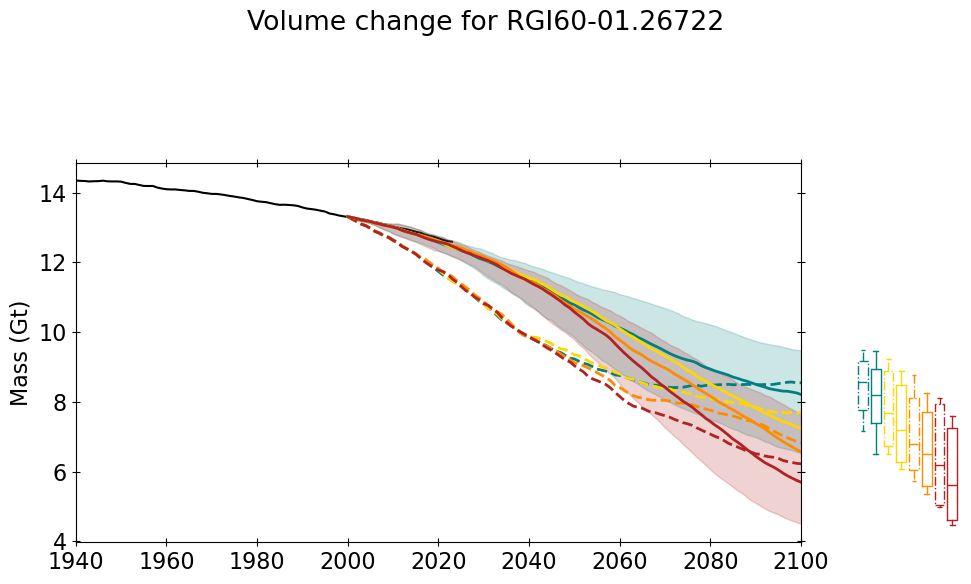

In [11]:
fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(2, 2, width_ratios=[10, 1.5], height_ratios=[1, 6])
fig.subplots_adjust(wspace=-1.5)
gs1 = fig.add_subplot(gs[0, 0])
gs2 = fig.add_subplot(gs[0, 1], sharey=gs1)
gs3 = fig.add_subplot(gs[1, 0], sharex=gs1)
gs4 = fig.add_subplot(gs[1, 1], sharey=gs3, sharex=gs2)
axes = (gs3, gs4)

n = option_calibs.count('MCMC')
vol_mcmc2100_box, vol_kp2100_box = [], []

# plot data
all_mcmc_vol = [[] for _ in range(n)]
all_kp_vol = [[] for _ in range(len(nc_datas[0]) - n)]
for j, nc_gcm in enumerate(nc_datas):
    gcm_name = gcms[j]
    i_count, i_count_kp = 0, 0
    vol_mcmc_2100, vol_kp_2100 = [], []
    # axes[0].plot([],[], c=cmap((j+1)/len(nc_datas)), ls='-', label=f'{gcm_name}')
    for i, nc_data in enumerate(nc_gcm):
        scenario = scenarios[i]
        option_calib = option_calibs[i]
        glac_no = nc_data.variables['RGIId'][:].values[0]
        cftime = nc_data.variables['time'][:]
        years = nc_data.variables['year'][:]  

        if option_calib == 'opt':
            months = nc_data.variables['month'][:]
            unique_yr = nc_data.variables['year_unique'][:]
            temp_monthly = nc_data.variables['glac_temp_annual_mean'][:][0,:]
            prec_monthly = nc_data.variables['glac_prec_annual_mean'][:][0,:]
            area_annual = nc_data.variables['glac_area_annual_mean'][:][0,:]
            mass_annual = nc_data.variables['glac_mass_annual_mean'][:][0,:]
            mass_annual_Gt = mass_annual/1e12
            vol_annual_km3 = nc_data.variables['glac_vol_annual_mean'][:][0,:]
            
        else:
            months = [cftime_to_datetime(d) for d in np.array(cftime)]
            temp_monthly = nc_data.variables['glac_temp_monthly'][:][0,:]
            prec_monthly = nc_data.variables['glac_prec_monthly'][:][0,:]
            area_annual = nc_data.variables['glac_area_annual'][:][0,:]
            mass_annual = nc_data.variables['glac_mass_annual'][:][0,:]
            mass_annual_Gt = mass_annual/1e12
            vol_annual = mass_annual/rho
            vol_annual_km3 = vol_annual/1e9

        if option_calib == 'MCMC':
            mcmc_years = years.copy()
            vol_mcmc_2100.append(mass_annual_Gt[-1])
            all_mcmc_vol[i_count].append(mass_annual_Gt)
            # l1, = axes[0].plot(years, mass_annual_Gt, c=cmap((i_count+1)/n), ls='-', lw=0.3, alpha=0.6)#, label=f'{glac_no}, {gcm_name}, {scenario}')
            i_count += 1
        else:
            kp_years = years.copy()
            vol_kp_2100.append(mass_annual_Gt[-1])
            all_kp_vol[i_count_kp].append(mass_annual_Gt)
            # axes[0].plot(years, mass_annual_Gt, c=cmap((i_count_kp+1)/n), ls='--', lw=0.3, alpha=0.6)
            i_count_kp += 1
        
        # annotate / label
        if j == len(nc_datas)-1 and option_calib == 'MCMC':
            axes[0].fill_between([],[], color=cmap((i_count)/n), ls='-', label=f'{scenario}')
            # axes[0].plot([],[], c='k', ls=lss[i], label=f'{scenario} ({option_calib})')
            # ax.annotate(f'f_snow: {ddfsnow}\nk_p: {kp}\nT_bias: {tbias}', 
            #             (0.02,0.05+(i*0.15)), xycoords='axes fraction', c=cmap((j+1)/len(nc_datas)), size=12)
    
    vol_mcmc2100_box.append(vol_mcmc_2100)
    vol_kp2100_box.append(vol_kp_2100)

# plot mean of MCMC GCMs for each SSP
mcmc_gcm_meds_2000, mcmc_gcm_meds_2020, mcmc_gcm_meds = [], [], []
for i in range(n):
    mcmc_gcm_mean = np.mean(np.vstack(all_mcmc_vol[i]), axis=0) # Rounce et al. MCMC params
    mcmc_gcm_med = np.median(np.vstack(all_mcmc_vol[i]), axis=0)
    mcmc_gcm_min = np.min(np.vstack(all_mcmc_vol[i]), axis=0)
    mcmc_gcm_max = np.max(np.vstack(all_mcmc_vol[i]), axis=0)
    l2, = axes[0].plot(mcmc_years, mcmc_gcm_med, c=cmap((i+1)/n), ls=lss[0], lw=2, alpha=1)
    # print('MCMC Volume initial and final:', float(mcmc_gcm_med[0]), float(mcmc_gcm_med[-1]))
    mcmc_gcm_meds_2000.append(mcmc_gcm_med[0])
    mcmc_gcm_meds_2020.append(mcmc_gcm_med[20])
    mcmc_gcm_meds.append(mcmc_gcm_med[-1])
    if i==0:
        axes[0].plot([],[], c='k', ls=lss[0], label=f'Modern calibration')

kp_gcm_meds_2000, kp_gcm_meds_2020, kp_gcm_mins, kp_gcm_maxs, kp_gcm_stds, kp_gcm_meds = [], [], [], [], [], []
for i in range(len(nc_datas[0]) - n):
    kp_gcm_mean = np.mean(np.vstack(all_kp_vol[i]), axis=0) # our specified params
    kp_gcm_med = np.median(np.vstack(all_kp_vol[i]), axis=0)
    kp_gcm_min = np.min(np.vstack(all_kp_vol[i]), axis=0)
    kp_gcm_max = np.max(np.vstack(all_kp_vol[i]), axis=0)
    kp_gcm_std = np.std(np.vstack(all_kp_vol[i]), axis=0)
    l2, = axes[0].plot(kp_years, kp_gcm_med, c=cmap((i+1)/n), ls=lss[1], lw=2, alpha=1)
    if i == 0 or i == 3:
        axes[0].fill_between(kp_years, kp_gcm_min, kp_gcm_max, color=cmap((i+1)/n), alpha=0.2)
    kp_gcm_meds_2000.append(kp_gcm_med[0])
    kp_gcm_meds_2020.append(kp_gcm_med[20])
    kp_gcm_meds.append(kp_gcm_med[-1])
    kp_gcm_mins.append(kp_gcm_min[-1])
    kp_gcm_maxs.append(kp_gcm_max[-1])
    kp_gcm_stds.append(kp_gcm_std[-1])
    # print('OPT Volume initial and final:', float(kp_gcm_med[0]), float(kp_gcm_med[-1]))
    if i == 0:
        axes[0].plot([],[], c='k', ls=lss[1], label=f'Historical calibration')

    #  # ------------ To show historical calibration from 1940 (these 3 lines) ------------------
    # axes[0].plot(kp1940_yrs, kp1940_gts[i], c=cmap((i+1)/n), ls=':', lw=2, alpha=1) # show historical calibration from 1940
    # if i == 0:
    #     axes[0].plot([],[], c='k', ls=':', label=f'Historical calibration (from 1940)')

# test statistical significance
for i in range(n):
    stat, p_wilcox = wilcoxon(np.array(vol_mcmc2100_box)[:,i], np.array(vol_kp2100_box)[:,i]) # perform Wilcoxon signed-rank test
    print(f'{scenarios[i]} Wilcoxon p-value: {np.round(p_wilcox,5)}') # p<0.05
    print(f'\tmean volume: {np.mean([np.array(vol_mcmc2100_box)[:,i], np.array(vol_kp2100_box)[:,i]]):.2f}')
    print(f'\tWasserstein distance: {wasserstein_distance(np.array(vol_mcmc2100_box)[:,i], np.array(vol_kp2100_box)[:,i]):.2f}')
    # Wasserstein distance is basically the mean difference between the datasets
    
    stat1, p1 = shapiro(np.array(vol_mcmc2100_box)[:,i]) # Shapiro-Wilk test for normally distributed data
    stat2, p2 = shapiro(np.array(vol_kp2100_box)[:,i])
    if p1 > 0.05 and p2 > 0.05:  # t-test for normallydistributed data
        stat, p = ttest_ind(np.array(vol_mcmc2100_box)[:,i], np.array(vol_kp2100_box)[:,i])
        print(f'{scenarios[i]} t-test p-value: {np.round(p,5)}\n') # p<0.05
    else:  # Mann-Whitney test for non-normally distributed data
        print(f'{scenarios[i]}: At least one of the arrays is not normally distributed')
        stat, p = mannwhitneyu(np.array(vol_mcmc2100_box)[:,i], np.array(vol_kp2100_box)[:,i])
        print(f'\t\tMann-Whitney test p-value: {np.round(p,5)}\n')

for i in range(n):
    stat1, p1 = shapiro(np.array(vol_mcmc2100_box)[:,i])  # Shapiro-Wilk test for normally distributed data
    stat2, p2 = shapiro(np.array(vol_kp2100_box)[:,i])
    if p1 > 0.05 and p2 > 0.05: # t-test for normally distributed data
        stat, p = ttest_ind(np.array(vol_mcmc2100_box)[:,i], np.array(vol_kp2100_box)[:,i])
        print(f'{scenarios[i]} p-value: {np.round(p,5)}') # p<0.05
    else: # Mann-Whitney test for non-normally distributed data
        print(f'{scenarios[i]}: At least one of the arrays is not normally distributed')
        stat, p = mannwhitneyu(np.array(vol_mcmc2100_box)[:,i], np.array(vol_kp2100_box)[:,i])
        print(f'\t\tp-value: {np.round(p,5)}')

    
# mcmc calibration box-and-whiskers 
boxplot_y = 5.1 # 7 for Kenn, 5.5 (5.1) for Root
mcmcbox = axes[1].boxplot(np.array(vol_mcmc2100_box), widths=1.5, positions=np.arange(0, 16, 4))
axes[1].axis('off')
for i, (label, boxplot, meds) in enumerate(zip(['SSP1-2.6', 'SSP2-4.5', 'SSP3-7.0', 'SSP5-8.5'], mcmcbox['boxes'], mcmcbox['medians'])):
    # axes[1].annotate(label, (boxplot.get_xdata()[0]+0.5, boxplot_y), xytext=(3,0), textcoords='offset points', 
    #                  va='top', ha='center', rotation=90, size=12) 
    boxplot.set_color(cmap((i+1)/n)) # fix colors
    meds.set_color(cmap((i+1)/n))
    boxplot.set_linestyle('-.')
    meds.set_linestyle('-.')

for i, (whisker, cap) in enumerate(zip(mcmcbox['whiskers'], mcmcbox['caps'])): # whisker and cap color
    whisker.set_color(cmap(((i//2)+1)/n))
    cap.set_color(cmap(((i//2)+1)/n))
    whisker.set_linestyle('-.')
    cap.set_linestyle('-.')

# historical calibration box-and-whiskers
kpbox = axes[1].boxplot(np.array(vol_kp2100_box), widths=1.5, positions=np.arange(2, 18, 4))
for i, (label, boxplot, meds) in enumerate(zip(['SSP1-2.6', 'SSP2-4.5', 'SSP3-7.0', 'SSP5-8.5'], kpbox['boxes'], kpbox['medians'])):
    boxplot.set_color(cmap((i+1)/n)) # fix colors
    meds.set_color(cmap((i+1)/n))

for i, (whisker, cap) in enumerate(zip(kpbox['whiskers'], kpbox['caps'])): # whisker and cap color
    whisker.set_color(cmap(((i//2)+1)/n))
    cap.set_color(cmap(((i//2)+1)/n))

# plot ERA5 data
axes[0].plot(era5_yrs, era5_gt, c='k', ls='-', zorder=0)


# set labels
fig.suptitle(f'Volume change for {glac_no}')
axes[0].set_ylabel('Mass (Gt)') 
axes[0].set_xlim(min(years), 2100)
axes[0].set_xlim(1940, 2100)
# axes[0].set_ylim(0,)
# axes[0].yaxis.tick_right()
axes[0].tick_params(axis='both', which='both', direction='inout', right=True, top=True, length=6)

# add legend
# fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# axes[0].legend(loc='lower left', frameon=False) # use this legend
# axes[0].annotate(f'f_snow: {ddfsnow}\nk_p: {kp}\nT_bias: {tbias}', (0.02,0.05), xycoords='axes fraction', c='k', size=12)

gs1.axis('off')
gs2.axis('off')
fig.tight_layout()
plt.show()


ssp126 p-value: 0.00018
ssp245 p-value: 0.00426
ssp370 p-value: 3e-05
ssp585 p-value: 0.00917


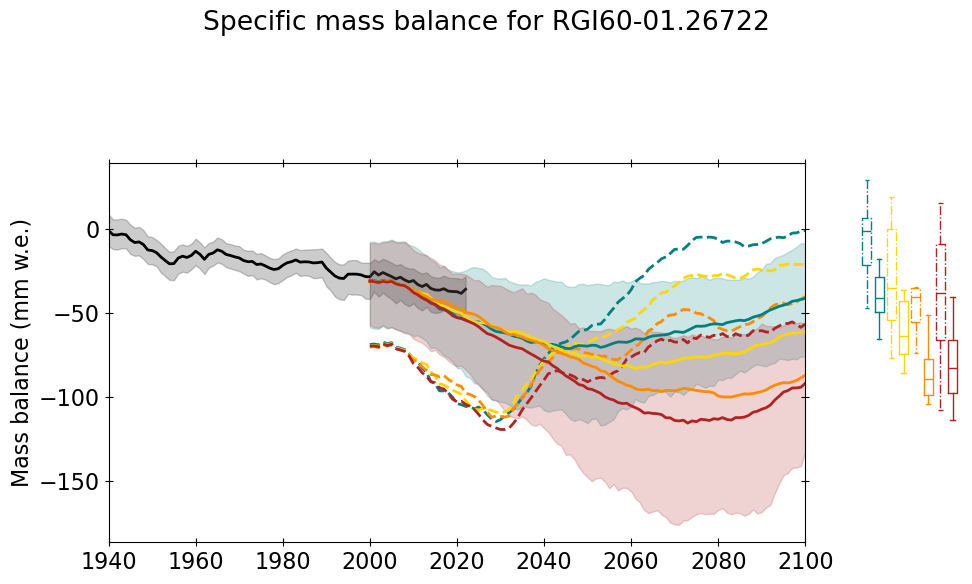

In [12]:
fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(2, 2, width_ratios=[10, 1.5], height_ratios=[1, 6])
gs1 = fig.add_subplot(gs[0, 0])
gs2 = fig.add_subplot(gs[0, 1], sharey=gs1)
gs3 = fig.add_subplot(gs[1, 0], sharex=gs1)
gs4 = fig.add_subplot(gs[1, 1], sharey=gs3, sharex=gs2)
axes = (gs3, gs4)

n = option_calibs.count('MCMC')
mb_mcmc2100_box, mb_kp2100_box = [], []

# plot data
all_mcmc_mb = [[] for _ in range(n)]
all_kp_mb = [[] for _ in range(len(nc_datas[0]) - n)]
for j, nc_gcm in enumerate(nc_datas):
    gcm_name = gcms[j]
    i_count, i_count_kp = 0, 0
    mb_mcmc_2100, mb_kp_2100 = [], []
    # axes[0].plot([],[], c=cmap((j+1)/len(nc_datas)), ls='-', label=f'{gcm_name}')
    for i, nc_data in enumerate(nc_gcm):
        scenario = scenarios[i]
        option_calib = option_calibs[i]
        glac_no = nc_data.variables['RGIId'][:].values[0]
        cftime = nc_data.variables['time'][:]
        years = nc_data.variables['year'][:]  

        if option_calib == 'opt':
            months = nc_data.variables['month'][:]
            unique_yr = nc_data.variables['year_unique'][:]
            temp_monthly = nc_data.variables['glac_temp_annual_mean'][:][0,:]
            prec_monthly = nc_data.variables['glac_prec_annual_mean'][:][0,:]
            area_annual = nc_data.variables['glac_area_annual_mean'][:][0,:]
            mass_annual = nc_data.variables['glac_mass_annual_mean'][:][0,:]
            mb_annual = nc_data.variables['glac_mb_annual_mean'][:][0,:]
            vol_annual_km3 = nc_data.variables['glac_vol_annual_mean'][:][0,:]
            smb_annual = 1000*np.array(np.array(mb_annual)/np.array(area_annual[:-1]))
        else:
            months = [cftime_to_datetime(d) for d in np.array(cftime)]
            temp_monthly = nc_data.variables['glac_temp_monthly'][:][0,:]
            prec_monthly = nc_data.variables['glac_prec_monthly'][:][0,:]
            area_annual = nc_data.variables['glac_area_annual'][:][0,:]
            mass_annual = nc_data.variables['glac_mass_annual'][:][0,:]
            mb_monthly = nc_data.variables['glac_massbaltotal_monthly'][:][0,:]
            vol_annual = mass_annual/rho
            vol_annual_km3 = vol_annual/1e9
    
            # annunal temp and precip
            months_yr = np.array([d.year for d in months])
            unique_yr = np.unique(months_yr)
            mb_annual = []
            for yr in unique_yr:
                mask = months_yr == yr
                mb_annual.append(np.mean(mb_monthly[mask]))
            smb_annual = 1000*np.array(mb_annual/area_annual[:-1]) # specific mb in mm w.e.
        
        if option_calib == 'MCMC':
            mb_mcmc_2100.append(smb_annual[-1])
            all_mcmc_mb[i_count].append(smb_annual)
            # l1, = axes[0].plot(unique_yr, smb_annual, c=cmap((i_count+1)/n), ls='-', lw=0.3, alpha=0.6)#, label=f'{glac_no}, {gcm_name}, {scenario}')
            i_count += 1
        else:
            mb_kp_2100.append(smb_annual[-1])
            all_kp_mb[i_count_kp].append(smb_annual)
            i_count_kp += 1
        
        # annotate / label
        if j == len(nc_datas)-1 and option_calib == 'MCMC':
                axes[0].fill_between([],[], color=cmap((i_count)/n), ls='-', label=f'{scenario}')
                # axes[0].plot([],[], c='k', ls=lss[i], label=f'{scenario} ({option_calib})')
                # ax.annotate(f'f_snow: {ddfsnow}\nk_p: {kp}\nT_bias: {tbias}', 
                #             (0.02,0.05+(i*0.15)), xycoords='axes fraction', c=cmap((j+1)/len(nc_datas)), size=12)
    
    mb_mcmc2100_box.append(mb_mcmc_2100)
    mb_kp2100_box.append(mb_kp_2100)

# plot mean of MCMC GCMs for each SSP
for i in range(n):
    mcmc_gcm_mean = np.mean(np.vstack(all_mcmc_mb[i]), axis=0) # Rounce et al. MCMC params
    mcmc_gcm_min = np.min(np.vstack(all_mcmc_mb[i]), axis=0)
    mcmc_gcm_max = np.max(np.vstack(all_mcmc_mb[i]), axis=0)

    df_mcmc_smooth = pd.DataFrame({'year': unique_yr, 'mcmc_gcm_mean': mcmc_gcm_mean})
    df_mcmc_smooth['mcmc_gcm_mean_smooth'] = df_mcmc_smooth['mcmc_gcm_mean'].rolling(window=11, center=True, min_periods=1).mean()
    l2, = axes[0].plot(unique_yr, df_mcmc_smooth['mcmc_gcm_mean_smooth'], c=cmap((i+1)/n), ls=lss[0], lw=2, alpha=1)
    if i==0:
        axes[0].plot([],[], c='k', ls=lss[0], label=f'Modern params')

kp_gcm_meds = []
for i in range(len(nc_datas[0]) - n):
    kp_gcm_mean = np.mean(np.vstack(all_kp_mb[i]), axis=0) # our specified params
    kp_gcm_med = np.median(np.vstack(all_kp_mb[i]), axis=0)
    kp_gcm_min = np.min(np.vstack(all_kp_mb[i]), axis=0)
    kp_gcm_max = np.max(np.vstack(all_kp_mb[i]), axis=0)

    df_gcm_smooth = pd.DataFrame({'year': unique_yr, 'kp_gcm_mean': kp_gcm_mean, 'kp_gcm_min': kp_gcm_min, 'kp_gcm_max': kp_gcm_max})
    df_gcm_smooth['kp_gcm_mean_smooth'] = df_gcm_smooth['kp_gcm_mean'].rolling(window=11, center=True, min_periods=1).mean()
    df_gcm_smooth['kp_gcm_min_smooth'] = df_gcm_smooth['kp_gcm_min'].rolling(window=11, center=True, min_periods=1).mean()
    df_gcm_smooth['kp_gcm_max_smooth'] = df_gcm_smooth['kp_gcm_max'].rolling(window=11, center=True, min_periods=1).mean()
    l2, = axes[0].plot(unique_yr, df_gcm_smooth['kp_gcm_mean_smooth'], c=cmap((i+1)/n), ls=lss[1], lw=2, alpha=1)
    if i == 0 or i == 3:
        axes[0].fill_between(unique_yr, df_gcm_smooth['kp_gcm_min_smooth'], df_gcm_smooth['kp_gcm_max_smooth'], 
                             color=cmap((i+1)/n), alpha=0.2)
    kp_gcm_meds.append(kp_gcm_med[-1])
    if i == 0:
        axes[0].plot([],[], c='k', ls=lss[1], label=f'Historical params')

# plot ERA5 data
df_era5_smooth = pd.DataFrame({'year': era5_yrs[:-1], 'kp_gcm_mean': era5_smb, 'kp_gcm_min': era5_smb_min, 'kp_gcm_max': era5_smb_max})
df_era5_smooth['kp_gcm_mean_smooth'] = df_era5_smooth['kp_gcm_mean'].rolling(window=11, center=True, min_periods=1).mean()
df_era5_smooth['kp_gcm_min_smooth'] = df_era5_smooth['kp_gcm_min'].rolling(window=11, center=True, min_periods=1).mean()
df_era5_smooth['kp_gcm_max_smooth'] = df_era5_smooth['kp_gcm_max'].rolling(window=11, center=True, min_periods=1).mean()

axes[0].plot(era5_yrs[:-1], df_era5_smooth['kp_gcm_mean_smooth'], c='k', ls='-', lw=2, alpha=1, zorder=0)

axes[0].fill_between(era5_yrs[:-1], df_era5_smooth['kp_gcm_min_smooth'], df_era5_smooth['kp_gcm_max_smooth'], 
                     color='k', alpha=0.2, zorder=0)

# test statistical significance
for i in range(n):
    stat1, p1 = shapiro(np.array(mb_mcmc2100_box)[:,i]) # Shapiro-Wilk test to determine normally distributed data
    stat2, p2 = shapiro(np.array(mb_kp2100_box)[:,i])
    if p1 > 0.05 and p2 > 0.05: # t-test for normallydistributed data
        stat, p = ttest_ind(np.array(mb_mcmc2100_box)[:,i], np.array(mb_kp2100_box)[:,i])
        print(f'{scenarios[i]} p-value: {np.round(p,5)}') # p<0.05
    else: # Mann-Whitney test for non-normallydistributed data
        print(f'{scenarios[i]}: At least one of the arrays is not normally distributed')
        stat, p = mannwhitneyu(np.array(mb_mcmc2100_box)[:,i], np.array(mb_kp2100_box)[:,i])
        print(f'\t\tp-value: {np.round(p,5)}')
    
# mcmc calibration box-and-whiskers 
boxplot_y = -120 # -260 kenn, -120 root
mcmcbox = axes[1].boxplot(np.array(mb_mcmc2100_box), widths=1.5, positions=np.arange(0, 16, 4), showfliers=False)
axes[1].axis('off')
for i, (label, boxplot, meds) in enumerate(zip(['SSP1-2.6', 'SSP2-4.5', 'SSP3-7.0', 'SSP5-8.5'], mcmcbox['boxes'], mcmcbox['medians'])):
    # axes[1].annotate(label, (boxplot.get_xdata()[0]+0.5, boxplot_y), xytext=(3,0), textcoords='offset points', 
    #                  va='top', ha='center', rotation=90, size=12) 
    boxplot.set_color(cmap((i+1)/n)) # fix colors
    meds.set_color(cmap((i+1)/n))
    boxplot.set_linestyle('-.')
    meds.set_linestyle('-.')

for i, (whisker, cap) in enumerate(zip(mcmcbox['whiskers'], mcmcbox['caps'])): # whisker and cap color
    whisker.set_color(cmap(((i//2)+1)/n))
    cap.set_color(cmap(((i//2)+1)/n))
    whisker.set_linestyle('-.')
    cap.set_linestyle('-.')

# historical calibration box-and-whiskers
kpbox = axes[1].boxplot(np.array(mb_kp2100_box), widths=1.5, positions=np.arange(2, 16, 4), showfliers=False)
for i, (label, boxplot, meds) in enumerate(zip(['SSP1-2.6', 'SSP2-4.5', 'SSP3-7.0', 'SSP5-8.5'], kpbox['boxes'], kpbox['medians'])):
    boxplot.set_color(cmap((i+1)/n)) # fix colors
    meds.set_color(cmap((i+1)/n))

for i, (whisker, cap) in enumerate(zip(kpbox['whiskers'], kpbox['caps'])): # whisker and cap color
    whisker.set_color(cmap(((i//2)+1)/n))
    cap.set_color(cmap(((i//2)+1)/n))  

# set labels
fig.suptitle(f'Specific mass balance for {glac_no}')
axes[0].set_ylabel('Mass balance (mm w.e.)') 
axes[0].set_xlim(min(years), 2100)
axes[0].set_xlim(1940, 2100)
# axes[0].set_ylim(0,)
# axes[0].yaxis.tick_right()
axes[0].tick_params(axis='both', which='both', direction='inout', right=True, top=True, length=6)

# add legend
# axes[0].legend(loc='lower left', frameon=False, facecolor='none')
# axes[0].legend(loc='lower left')

gs1.axis('off')
gs2.axis('off')
fig.tight_layout()
plt.show()
